### 허프변환
에지 세션화를 사용한 방법에서는 비교적 잘 연결할 수 있는 상황을 가정한다.  
하지만 현실에서는 연결 관계가 명확하지 않거나 잡음으로 인해 작은 조각을 끊어져 있는 경우도 종종 마주한다.  
허프는 이러한 상황에서 연결 과정 없이 바로 직선을 찾아내는 허프 변환(Hough Transform)을 고안했다.   
에지 세션화 방식은 어떤 화소의 이웃을 조사하는 지역 연산(Local operation)임에 비해, 허프 변환은 전체 공간을 조사하는 전역 연산(Global operation)이다. ㄸ한 사람이 일직선 상에 있다고 지각하는 점들을 한 곳으로 모으는 원리를 사용해 일종의 지각 군집화(Perceptual grouping)라고 볼 수 있다.

허프변환의 원리는 직선의 방정식을 찾아내는 것이다.  기울기와 y절편이 축인 공간에서는 기울기가 무한대인 상황이 있기 때문에 다음의 식을 직선의 방정식으로 삼는다.
$$
ycos(\theta)+xsin(\theta)=\rho
$$
이 식의 그래프는 아래와 같다.

![](./data/hough_ex1.jpg)

또 하나 고려해야 할 점은 세 점이 완벽하게 동일한 직선 위에 놓여 있다고 가정했지만 이산 공간에서는 어느 정도의 오류는 필연적으로 발생한다. 허프 변환은 오류를 견디기 위해 구간을 양자화 한다. theta와 rho가 가질 수 있는 범위는 각각 -90 <= theta <= 90 와 -D <= rho <=D이다.  
D는 이미지의 좌측 상단에서 우측 하단까지의 거리이다.

### 코드구현
다음과 같이 세 점이 있다고 가정했다.

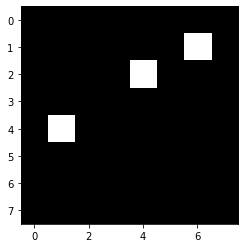

In [1]:
import numpy as np
import matplotlib.pyplot as plt

test_im = np.zeros((8,8))
test_im[1,6]=255
test_im[2,4]=255
test_im[4,1]=255
plt.imshow(test_im,cmap='gray')
plt.show()

theta의 범위는 -90에서 90으로 하고, D는 다음과 같이 구한다.
그리고 양자화는 D의 int값으로 설정했다.

In [2]:
def cal_D_max(img):
    return np.sqrt((len(img)-1)**2 + (len(img[0])-1)**2)

theta_min_max=[-90,90]
D = cal_D_max(test_im)
quenti=[int(D),int(D)]
rho_min_max=[D*-1,D]

각 값의 최소값에 -1을 곱한 값이 offset 값이 되고 현재 값에서 양자화 하는 단위로 나누면 양자화된 index를 구할 수 있다.
마지막 부분은 원래의 그림에서 직선 부분은 빨갛게 칠하는 부분이다.  
현재 theta-rho 공간에서 최대값이 3이기 때문에 임계값을 3으로 설정했다.

In [3]:
def hough(canny_img, quenti,theta_range,rho_range,T):
    def cal_rho(theta,y,x):
        theta = theta/180*np.pi
        return y*np.cos(theta)+x*np.sin(theta)
    def cal_y(x,theta,rho):
        theta = theta/180*np.pi
        return (rho-x*np.sin(theta))/np.cos(theta)

    rho_offset = rho_range[0]*-1
    theta_offset = theta_range[0]*-1
    rho_step = (rho_range[1] - rho_range[0]) / quenti[0]
    theta_step = (theta_range[1] - theta_range[0]) / quenti[1]
    start_theta = (theta_range[0]*2+theta_step)/2
    theta_list = np.arange(start_theta,theta_range[1],theta_step)
    start_rho = (rho_range[0]*2+rho_step)/2
    rho_list = np.arange(start_rho, rho_range[1], rho_step)

    A = np.zeros(quenti,np.uint8)
    hough_img=np.zeros([canny_img.shape[0],canny_img.shape[1],3])
    for y in range(len(canny_img)):
        for x in range(len(canny_img[0])):
            if canny_img[y,x]:
                for i in theta_list:
                    rh = cal_rho(i,y,x)
                    if rh>=rho_range[0] and rh<rho_range[1]:
                        n_x =(i+theta_offset)//theta_step
                        n_y = (rh+rho_offset)//rho_step
                        A[int(n_y),int(n_x)]+=1
    A = A>=T

    for rho in range(len(A)):
        for theta in range(len(A[0])):
            if A[rho,theta]:
                for x in range(len(canny_img[0])):
                    y = cal_y(x,theta_list[theta],rho_list[rho])
                    if y>=0 and y<len(canny_img)-0.5:
                        hough_img[int(y+0.5),x,0]=1

    hough_img[..., 1] = np.where(hough_img[...,0]>0,0,canny_img)
    hough_img[..., 2] = np.where(hough_img[...,0] > 0, 0, canny_img)
    hough_img[..., 0] = np.where(hough_img[..., 0] > 0, 255, canny_img)
    return np.uint8(hough_img)

결과는 다음과 같다.

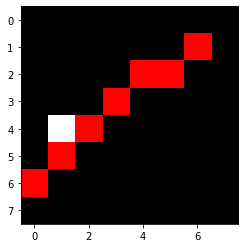

In [4]:
hough_img = hough(test_im,quenti,theta_min_max,rho_min_max,3)
plt.imshow(hough_img,cmap='gray')
plt.show()